# Exploring Crime data in Chicago

The objective of this notebook is to analyze a large dataset using PySpark.
I explore the `spark.sql` module and try to answer some questions about the dataset along the way! 

## Download and install Spark

In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

## Setup environment

In [7]:
import pandas as pd
import os
from pyspark.sql.functions import to_timestamp,col,lit
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

The size of this dataset is 1.61 GB and it can be accessed here: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

In [5]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD

--2021-05-21 00:03:39--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [                <=> ]   1.61G  1.55MB/s    in 19m 28s 

2021-05-21 00:23:08 (1.41 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1728628291]



In [4]:
!ls

sample_data  spark-2.3.1-bin-hadoop2.7	spark-2.3.1-bin-hadoop2.7.tgz


In [6]:
# renaming the file and saving as csv
!mv rows.csv\?accessType\=DOWNLOAD reported_crimes.csv

I filter the data to keep only the crimes reported before 2018-11-11

In [8]:
# Filtering down the data to crimes reported only before 2018-11-11
rc = spark.read.csv('reported_crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [ ]:
# Checking the files in the directory
!ls

reported_crimes.csv  spark-2.3.1-bin-hadoop2.7	    spark-warehouse
sample_data	     spark-2.3.1-bin-hadoop2.7.tgz


## Differences between Pandas and PySpark

- Reading in data from csv files looks like:

```python:
# Pandas
df=pd.read_csv(filepath, header=...)

# PySpark
df=spark.read.csv(filepath, header=...)
```

- To view first few rows

```python:
# Pandas
df.head(n)

# PySpark
df.take(n) # Return a list
df.collect() # Be careful with this because it pulls all the data
df.show(n)
df.limit(n) # Returns a dataframe
df.head(n) # Returns an array/list
```


- For data types/schema:
Spark can detect the schema directly but it is better to define it ourselves.

```python:
# Pandas
df.dtypes

# PySpark
df.dtypes
df.printSchema()
```



Note: Check sourcecode here: http://spark.apache.org/docs/latest/api/python/search.html?q=limit



## Schemas

In [ ]:
# view current schema
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

To define our own schema:


In [ ]:
labels=[
        ('ID',StringType()),
 ('Case Number',StringType()),
 ('Date',TimestampType()),
 ('Block',StringType()),
 ('IUCR',StringType()),
 ('Primary Type',StringType()),
 ('Description',StringType()),
 ('Location Description',StringType()),
 ('Arrest',StringType()),
 ('Domestic',BooleanType()),
 ('Beat',StringType()),
 ('District',StringType()),
 ('Ward',StringType()),
 ('Community Area',StringType()),
 ('FBI Code',StringType()),
 ('X Coordinate',StringType()),
 ('Y Coordinate',StringType()),
 ('Year', IntegerType()),
 ('Updated On',StringType()),
 ('Latitude',DoubleType()),
 ('Longitude',DoubleType()),
 ('Location',StringType())
]

In [ ]:
# Defining our own schema
myschema=StructType([StructField(x[0],x[1],True) for x in labels])
myschema

StructType(List(StructField(ID,StringType,true),StructField(Case Number,StringType,true),StructField(Date,TimestampType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,StringType,true),StructField(Domestic,BooleanType,true),StructField(Beat,StringType,true),StructField(District,StringType,true),StructField(Ward,StringType,true),StructField(Community Area,StringType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,StringType,true),StructField(Y Coordinate,StringType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true)))

In [ ]:
rc_own_schema=spark.read.csv('reported_crimes.csv',schema=myschema)
rc_own_schema.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



This is one way to define our own schema. I will stick to the inferred schema going forward.

## Accessing columns

Accessing multiple columns:

```
# pandas
df[['col1','col2']]

# PySpark
df.select('col1','col2').show(5)
```

Adding a new column whose value is twice that of an existing column

```
# pandas
df['new_col']=2*df['col']

# PySpark
df.withColumn('Doublecol',2*df['col'])
```


Renaming a column

```
# pandas
df.rename(columns={'Existing':'New'})

# PySpark
df.withColumnRenamed(ExistingColName,NewColName)
```

In [ ]:
# To display only top 5 rows of "IUCR" column:

rc.select('IUCR').show(5)

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows



In [ ]:
rc.select(rc.IUCR).show(5)

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows



In [ ]:

rc.select(col('IUCR')).show(5)

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows



### To show only first 4 rows of columns CaseNumber, Date and Arrest

In [ ]:
rc.select('Case Number','Date','Arrest').show(4)

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   HY411648|2015-09-05 13:30:00| false|
|   HY411615|2015-09-04 11:30:00| false|
|   JC213529|2018-09-01 00:01:00| false|
|   HY411595|2015-09-05 12:45:00|  true|
+-----------+-------------------+------+
only showing top 4 rows



### To create a column of literals

In [ ]:
from pyspark.sql.functions import lit

In [ ]:
# Does not get saved but returns a new dataframe
rc.withColumn('One',lit(1)).show(4)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|One|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|

In [ ]:
rc.show(4)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

### To drop a column 'IUCR'

In [ ]:
rc=rc.drop('IUCR')
rc.show(4)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

## Row manipulation

**PySpark:**

- Filtering rows: `df.filter(col('column')>1) `
- To determine unique rows for a column: `df.select(column).distinct().show()`
- Sorting: `df.orderBy(col('colname'))`
- Append rows to a df: `df1.union(df2) `
Both dataframes should have the same columns and schema, otherwise the union will fail




#### Experimenting with unions

Add rows for 12th November 2018 to the dataset

In [55]:
one_day=spark.read.csv('reported_crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-12'))

In [56]:
one_day.count() # Number of reported crimes for the 12th of November

3

In [ ]:
# Appending this to our existing DataFrame rc
rc.union(one_day).show(5)

AnalysisException: ignored

We get an error because we dropped the 'IUCR' column from `rc` but not from `one_day`

In [57]:
# redefining rc
rc = spark.read.csv('reported_crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.union(one_day).orderBy('Date', ascending=False).show(5)

+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11516594|   JB528186|2018-11-12 00:00:00| 049XX S PRAIRIE AVE|2826|      OTHER OFFENSE|HARASSMENT BY ELE...|               OTHER|

### Most common reported crimes by Primary type

In [ ]:
rc.groupBy('Primary type').count().orderBy('count', ascending=False).show(10)

The highest reported crime in Chicago is **theft** followed by battery!

### What % of reported crimes lead to arrests?

In [ ]:
rc.select('Arrest').distinct().show()

In [10]:
# Checking the dtype - we see 'Arrest' is a string and not boolean!
rc.dtypes


[('ID', 'string'),
 ('Case Number', 'string'),
 ('Date', 'timestamp'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'string'),
 ('Domestic', 'string'),
 ('Beat', 'string'),
 ('District', 'string'),
 ('Ward', 'string'),
 ('Community Area', 'string'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'string'),
 ('Y Coordinate', 'string'),
 ('Year', 'string'),
 ('Updated On', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string'),
 ('Location', 'string')]

In [11]:
rc.filter(col('Arrest')=='true').count()/rc.select('Arrest').count()

0.2775452015886773

27% of crimes lead to arrests.

### What is the most frequent location where crimes are reported?

In [30]:
rc.groupBy('Location description').count().orderBy('count', ascending=False).show(10, truncate=False)

+------------------------------+-------+
|Location description          |count  |
+------------------------------+-------+
|STREET                        |1770581|
|RESIDENCE                     |1145285|
|APARTMENT                     |698513 |
|SIDEWALK                      |665557 |
|OTHER                         |256770 |
|PARKING LOT/GARAGE(NON.RESID.)|193743 |
|ALLEY                         |150911 |
|SCHOOL, PUBLIC, BUILDING      |142310 |
|RESIDENCE-GARAGE              |131597 |
|SMALL RETAIL STORE            |119269 |
+------------------------------+-------+
only showing top 10 rows



Streets and residences are the places where most crimes are reported. Apartment and residence have a similar connotation.

## Exploring functions

In [13]:
from pyspark.sql import functions

In [14]:
# Quick peek at all the available functions
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

Normally, we would need to only import the specific functions we have use for. For our given data and problem, we may not use all the available functions. 


Next, let's look at some String functions. The `Primary Type` field is in all-caps. Lets try to change its case and extract substrings.


In [15]:
from pyspark.sql.functions import lower, upper, substring

In [16]:
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [17]:
# Checking that Primary Type is in fact a String type field
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [18]:
# Displaying the first 4 rows
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'),1,4)).show(4)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
|              theft|              THEFT|                         THEF|
|              theft|              THEFT|                         THEF|
|          narcotics|          NARCOTICS|                         NARC|
+-------------------+-------------------+-----------------------------+
only showing top 4 rows



### Date Operations

Use this as a reference: https://docs.oracle.com/javase/8/docs/api/java/text/SimpleDateFormat.html


In [21]:
# How long does this data span?
from pyspark.sql.functions import min, max

rc.select(min(col('Date')), max(col('Date'))).show()

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2018-11-10 23:55:00|
+-------------------+-------------------+



In [22]:
# If I wanted to add a 3 day buffer to the above dates
from pyspark.sql.functions import date_add, date_sub

help(date_add)


Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [23]:
rc.select(date_sub(min(col('Date')),3), date_add(max(col('Date')),3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-13|
+----------------------+----------------------+



In [25]:
# Dealing with dates
from pyspark.sql.functions import to_date, to_timestamp, lit

In [27]:
# Christmas as a dataframe
df=spark.createDataFrame([('2009-12-25 13:30:00',)],['Christmas'])
df.show()

+-------------------+
|          Christmas|
+-------------------+
|2009-12-25 13:30:00|
+-------------------+



In [28]:
help(to_date)

Help on function to_date in module pyspark.sql.functions:

to_date(col, format=None)
    Converts a :class:`Column` of :class:`pyspark.sql.types.StringType` or
    :class:`pyspark.sql.types.TimestampType` into :class:`pyspark.sql.types.DateType`
    using the optionally specified format. Specify formats according to
    `SimpleDateFormats <http://docs.oracle.com/javase/tutorial/i18n/format/simpleDateFormat.html>`_.
    By default, it follows casting rules to :class:`pyspark.sql.types.DateType` if the format
    is omitted (equivalent to ``col.cast("date")``).
    
    >>> df = spark.createDataFrame([('1997-02-28 10:30:00',)], ['t'])
    >>> df.select(to_date(df.t).alias('date')).collect()
    [Row(date=datetime.date(1997, 2, 28))]
    
    >>> df = spark.createDataFrame([('1997-02-28 10:30:00',)], ['t'])
    >>> df.select(to_date(df.t, 'yyyy-MM-dd HH:mm:ss').alias('date')).collect()
    [Row(date=datetime.date(1997, 2, 28))]
    
    .. versionadded:: 2.2



In [29]:
# To extract date and time info from the Date field
df.select(to_date(col('Christmas'),'yy-MM-dd HH:mm:ss').alias('Date'), to_timestamp(col('Christmas'),'yy-MM-dd HH:mm:ss').alias('Time')).show()

+----------+-------------------+
|      Date|               Time|
+----------+-------------------+
|2009-12-25|2009-12-25 13:30:00|
+----------+-------------------+



## Police Station data

Downloading data about police stations in Chicago to better understand the district information in our original crime data.

In [33]:
! wget -O police_station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD

--2021-05-21 01:23:59--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police_station.csv’

police_station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2021-05-21 01:23:59 (737 MB/s) - ‘police_station.csv’ saved [5699]



In [39]:
ps=spark.read.csv('police_station.csv', header=True)
ps.show(2)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

This dataset now has information about the district which we can use to join to our original crime dataset.

In [35]:
rc.cache()
rc.count()

6754298

In [40]:
ps.select(col('DISTRICT')).distinct().show(30, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|DISTRICT                                                                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|7                                                                                                                                                                                                    |
|15                                                                                                                                                                                                   |


We see that the `DISTRICT` field has both numbers and text. Next, we'll see what the `District` field in the crime dataset looks like.

In [41]:
rc.select(col('DISTRICT')).distinct().show(30, truncate=False)

+--------+
|DISTRICT|
+--------+
|009     |
|012     |
|024     |
|null    |
|031     |
|015     |
|006     |
|019     |
|020     |
|011     |
|025     |
|005     |
|003     |
|016     |
|018     |
|008     |
|022     |
|001     |
|014     |
|010     |
|004     |
|017     |
|007     |
|021     |
|002     |
+--------+



The crime dataset has leading zeros in the district numbers while the police dataset does not. We may need to do some padding.

In [42]:
from pyspark.sql.functions import lpad
help(lpad) # lpad performs left padding

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [44]:
ps.select(lpad(col('DISTRICT'),3,'0')).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [58]:
ps=ps.withColumn('FormattedDistrict',lpad(col('DISTRICT'),3,'0'))
ps.show(4)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+-----------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|FormattedDistrict|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+-----------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|              Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5

In [59]:
# Joining the datasets on District information

rc.join(ps, rc.District==ps.FormattedDistrict, how='left_outer').show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+-----------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|FormattedDi

We dont need all these columns, so dropping some unnecessary ones.

In [49]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'FormattedDistrict']

In [60]:
rc.join(ps, rc.District==ps.FormattedDistrict, how='left_outer').\
drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION').show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+-----------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|FormattedDistrict|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+-----------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|      

### Day of week

We check which day of the week, the most number of crimes are reported.

In [61]:
from pyspark.sql.functions import date_format

rc=rc.withColumn("day_of_week", date_format(col("Date"), "EEEE"))
rc.show()


+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-----------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|day_of_week|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-----------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC B

In [62]:
rc.groupBy(col('day_of_week')).count().orderBy('count', ascending=False).show(7)

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|     Friday|1017113|
|  Wednesday| 974031|
|    Tuesday| 968174|
|   Saturday| 965311|
|   Thursday| 964711|
|     Monday| 952870|
|     Sunday| 912088|
+-----------+-------+



Friday has the most number of crimes reported.

We can plot this data:



In [69]:
rc.groupBy(date_format(col('Date'),'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912088),
 Row(date_format(Date, E)='Mon', count=952870),
 Row(date_format(Date, E)='Thu', count=964711),
 Row(date_format(Date, E)='Sat', count=965311),
 Row(date_format(Date, E)='Wed', count=974031),
 Row(date_format(Date, E)='Fri', count=1017113),
 Row(date_format(Date, E)='Tue', count=968174)]

In [70]:
# Using list comprehension
dow=[x[0] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]
cases=[x[1] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]

Text(0.5, 1.0, 'Crime report - Chicago')

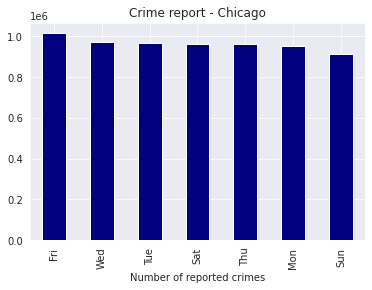

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
cp=pd.DataFrame({'Day_of_week':dow,'Case count':cases})
cp.sort_values('Case count',ascending=False).plot(kind='bar',color='navy',x='Day_of_week',y='Case count',legend=False)
plt.xlabel('Day of Week')
plt.xlabel('Number of reported crimes')
plt.title('Crime report - Chicago')

### Non criminal cases

Are there any non-criminal cases reported in the crime data?

In [65]:
# To find the number of non-criminal offences
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

We see that there are three flags for non-criminal activity:

- NON - CRIMINAL                   
- NON-CRIMINAL                     
- NON-CRIMINAL (SUBJECT SPECIFIED) 

In [66]:
nc=rc.filter((col('Primary Type')=='NON - CRIMINAL' )|(col('Primary Type')=='NON-CRIMINAL' )|(col('Primary Type')=='NON-CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-----------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|day_of_week|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-----------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|      NON - CRIMINAL|  

In [68]:
# To find the most common non-criminal activity, we use the description column

nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



Lost passports seem to be the most common non-criminal complaints.


## Using RDDs

In [77]:
# Creating an RDD using the police data

psrdd=sc.textFile('police_station.csv')
psrdd.first()

'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION'

In [78]:
ps_header=psrdd.first()

In [80]:
ps_rest=psrdd.filter(lambda line: line!=ps_header)
ps_rest.first()

'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

**Note:** `ps_header` contains the header of our data and `ps_rest` contains the actual rows of data in the rdd

In [81]:
type(ps_rest)

pyspark.rdd.PipelinedRDD

In [84]:
# Assume we want to find the number of police stations in the data

ps_rest.map(lambda line: line.split(',')).collect()

[['Headquarters',
  'Headquarters',
  '3510 S Michigan Ave',
  'Chicago',
  'IL',
  '60653',
  'http://home.chicagopolice.org',
  '',
  '',
  '',
  '1177731.401',
  '1881697.404',
  '41.83070169',
  '-87.62339535',
  '"(41.8307016873',
  ' -87.6233953459)"'],
 ['18',
  'Near North',
  '1160 N Larrabee St',
  'Chicago',
  'IL',
  '60610',
  'http://home.chicagopolice.org/community/districts/18th-district-near-north/',
  '312-742-5870',
  '312-742-5771',
  '312-742-5773',
  '1172080.029',
  '1908086.527',
  '41.90324165',
  '-87.64335214',
  '"(41.9032416531',
  ' -87.6433521393)"'],
 ['19',
  'Town Hall',
  '850 W Addison St',
  'Chicago',
  'IL',
  '60613',
  'http://home.chicagopolice.org/community/districts/19th-district-town-hall/',
  '312-744-8320',
  '312-744-4481',
  '312-744-8011',
  '1169730.744',
  '1924160.317',
  '41.94740046',
  '-87.65151202',
  '"(41.9474004564',
  ' -87.651512018)"'],
 ['20',
  'Lincoln',
  '5400 N Lincoln Ave',
  'Chicago',
  'IL',
  '60625',
  'http://

In [ ]:
ps_rest.map(lambda line: line.split(',')).count()

In [87]:
# To display the district, district name, address and zip for the station with district id=7
# We index by [0] since District ID is the first field in our data
(ps_rest.filter(lambda line: line.split(',')[0]=='7').
 map(lambda line: (line.split(',')[0],
                   line.split(',')[1],
                   line.split(',')[2],
                   line.split(',')[5],
                   )).collect())

[('7', 'Englewood', '1438 W 63rd St', '60636')]

In [88]:
# Same for police stations with ids 10 and 11
(ps_rest.filter(lambda line: line.split(',')[0] in ['10','11']).
 map(lambda line: (line.split(',')[0],
                   line.split(',')[1],
                   line.split(',')[2],
                   line.split(',')[5],
                   )).collect())

[('10', 'Ogden', '3315 W Ogden Ave', '60623'),
 ('11', 'Harrison', '3151 W Harrison St', '60612')]